# Local LLMs deployment
#### This notebook presents deployment of LLMs locally and analysing its hardware requirements and limitations.

#### Prepared by Anastasia Voronova and Andrey Noskov. All results are reproducable.


In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu\
"git+https://github.com/huggingface/optimum-intel.git"\
"nncf>=2.6.0"\
"gradio"\
"onnx" "onnxruntime" "einops" "transformers>=4.31.0"\
"openvino==2023.2.0.dev20230922"

In [ ]:
## login to huggingfacehub to get access to pretrained model
from huggingface_hub import notebook_login, whoami

try:
    whoami()
    print('Authorization token already provided')
except OSError:
    notebook_login()

In [ ]:
import ipywidgets as widgets

# RedPajama-Chat-3B-v1
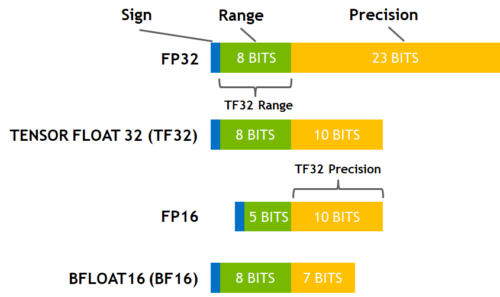

### 1. GPU

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

In [ ]:
# init
# tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")
model2 = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1", torch_dtype=torch.float16)
model2 = model.to('cuda:0')

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Alan Turing was a British mathematician, logician, cryptanalyst, and computer scientist. He is widely recognized as the father of computer science and artificial intelligence. Turing was a pioneer in computer science and artificial intelligence, and his work has had a significant impact on the development of computing technology.

Turing was born in 1912 in England and grew up in a middle-class family. He was fascinated by mathematics and science from a young age, and he completed his undergraduate studies at King's College, Cambridge, in 1933. During his time at Cambridge, he studied under the renowned mathematician G.H. Hardy,


'\nAlan Turing was a British mathematician, logician, cryptologist, and computer scientist. He is widely regarded as the father of computer science and artificial intelligence.\n'

In [ ]:
%%time
# infer
prompt = "<human>: Who is Alan Turing?\n<bot>:"
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Alan Turing was a British mathematician, logician, cryptanalyst, computer scientist, philosopher, and theoretical biologist. He was a pioneer of computer science, artificial intelligence, and the British post-World War II nuclear weapons programme.

Turing is best known for his work in mathematical biology and the early development of computers. He is often referred to as the "father of computer science". His work on the design of the first modern computer, the Turing machine, laid the foundations for theoretical computer science and artificial intelligence.

Turing was also a member of the British military intelligence during World War II, where
CPU times: user 8.84 s, sys: 10.4 ms, total: 8.85 s
Wall time: 10.2 s


Answer : Turing was born in 1912 in England and grew up in a middle-class family. He was fascinated by mathematics and science from a young age, and he completed his undergraduate studies at King's College, Cambridge, in 1933. During his time at Cambridge, he studied under the renowned mathematician G.H. Hardy,
\nAlan Turing was a British mathematician, logician, cryptologist, and computer scientist. He is widely regarded as the father of computer science and artificial intelligence.\n

### 2. GPU with int8

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install accelerate
!pip install -i https://test.pypi.org/simple/ bitsandbytes

In [ ]:
!pip install transformers==4.30

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# init
# tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1", device_map='auto', torch_dtype=torch.float16, load_in_8bit=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")

In [ ]:
%%time
# infer
prompt = "<human>: Who is Alan Turing?\n<bot>:"
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Alan Turing was a British mathematician and computer scientist who made important contributions to mathematics, cryptography, and computer science. He is widely regarded as the father of computer science and artificial intelligence.

Turing was a leading figure in the development of computers and artificial intelligence. He is best known for his work on the Turing machine, a theoretical model of a general-purpose computer, and for his contributions to the development of the Enigma code, which helped the Allies win World War II.

Turing's work on the Enigma code was instrumental in breaking the code, which allowed the Allies to win the war.
CPU times: user 28.2 s, sys: 73.4 ms, total: 28.3 s
Wall time: 28.6 s


Answer: Alan Turing was a British mathematician and computer scientist who made important contributions to mathematics, cryptography, and computer science. He is widely regarded as the father of computer science and artificial intelligence.

Turing was a leading figure in the development of computers and artificial intelligence. He is best known for his work on the Turing machine, a theoretical model of a general-purpose computer, and for his contributions to the development of the Enigma code, which helped the Allies win World War II.

Turing's work on the Enigma code was instrumental in breaking the code, which allowed the Allies to win the war.


### 3. CPU with bf16

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

MIN_TRANSFORMERS_VERSION = '4.25.1'

# check transformers version
assert transformers.__version__ >= MIN_TRANSFORMERS_VERSION, f'Please upgrade transformers to version {MIN_TRANSFORMERS_VERSION} or higher.'

# init
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1")
model = AutoModelForCausalLM.from_pretrained("togethercomputer/RedPajama-INCITE-Chat-3B-v1", torch_dtype=torch.bfloat16)

In [ ]:
%%time
# infer
prompt = "<human>: Who is Alan Turing?\n<bot>:"
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)
input_length = inputs.input_ids.shape[1]
outputs = model.generate(
    **inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.7, top_k=50, return_dict_in_generate=True
)
token = outputs.sequences[0, input_length:]
output_str = tokenizer.decode(token)
print(output_str)

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


 Alan Turing was a British mathematician and computer scientist who made important contributions to computer science, mathematics, and cryptography. He is widely regarded as the father of computer science and artificial intelligence.

Turing was born in 1912 in England and attended the King's College London, where he received a Ph.D. in mathematics in 1934. He worked at the National Physical Laboratory and the Government Code and Cypher School (GCHQ) during World War II, where he developed the first modern computers.

After the war, Turing worked at the Computing Machine Laboratory at the University of Manchester, where he helped develop the
CPU times: user 1min 15s, sys: 786 ms, total: 1min 16s
Wall time: 1min 21s


"""
Alan Turing was a British mathematician and computer scientist who made important contributions to the fields of mathematics, cryptography, and computer science. He is widely regarded as the father of computer science and artificial intelligence.
"""

## RedPajama results
### Inference time:
 1) GPU inference time -  8.84 s sec.

 2) int8 inference time - 28 sec. (multi-device mode)

 3) CPU inference time - 76 sec.


 ### Memory usage:

 1) 8 Gb 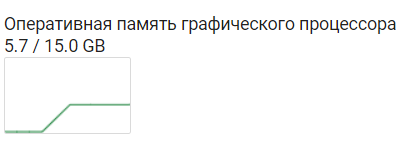

 2) 6 Gb
 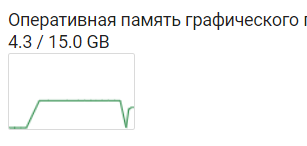

 3)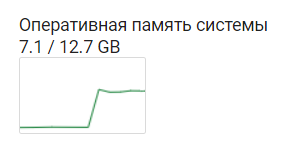

### P.S: на момент замеров скорости инференса Colab предоставил следующую машину:

In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [ ]:
!nvidia-smi

Thu Nov  9 11:57:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    26W /  70W |  12803MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

# Llama-2 7b with GPT-Q

In [ ]:
!git clone --branch 'gptq-4bit-32g-actorder_True' https://huggingface.co/TheBloke/Llama-2-7b-Chat-GPTQ

In [ ]:
!BUILD_CUDA_EXT=1 pip install auto-gptq  --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

In [ ]:
from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig

model_name_or_path = "Llama-2-7b-Chat-GPTQ"
model_basename = "model"

use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        model_basename=model_basename,
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)

"""
To download from a specific branch, use the revision parameter, as in this example:

model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        revision="gptq-4bit-32g-actorder_True",
        model_basename=model_basename,
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        quantize_config=None)
"""

1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


'\nTo download from a specific branch, use the revision parameter, as in this example:\n\nmodel = AutoGPTQForCausalLM.from_quantized(model_name_or_path,\n        revision="gptq-4bit-32g-actorder_True",\n        model_basename=model_basename,\n        use_safetensors=True,\n        trust_remote_code=True,\n        device="cuda:0",\n        quantize_config=None)\n'

In [ ]:
%%time
prompt = "Who is Alan Turing?"
prompt_template=f'''System: You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
User: {prompt}
Assistant:
'''

print("\n\n*** Generate:")

input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.7, max_new_tokens=512)
print(tokenizer.decode(output[0]))




*** Generate:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


<s> System: You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
User: Who is Alan Turing?
Assistant:
Alan Turing is a highly influential computer scientist, mathematician, and logician of the 20th century. He is widely regarded as the father of computer science and artificial intelligence. Turing made significant contributions to the field of computer science, including the development of the theoretical foundations of modern computer science, the design of the Automatic Computing Engine, and the development of the Turing machine, a theor

In [ ]:
%%time
# Inference can also be done using transformers' pipeline

# Prevent printing spurious transformers error when using pipeline with AutoGPTQ
logging.set_verbosity(logging.CRITICAL)

print("*** Pipeline:")
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.7,
    top_p=0.95,
    repetition_penalty=1.15
)

print(pipe(prompt_template)[0]['generated_text'])


*** Pipeline:


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


System: You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
User: Who is Alan Turing?
Assistant:
Alan Turing was a British mathematician, computer scientist, and codebreaker who lived from 1912 to 1954. He made significant contributions to the fields of mathematics, logic, and computer science, including the development of the theoretical foundations of modern computer science and the design of the Automatic Computing Engine, an early electronic computer. Turing is also known for his work on artificial intelligence and the concept of the 

In [ ]:
pip show optimum

Name: optimum
Version: 1.14.1
Summary: Optimum Library is an extension of the Hugging Face Transformers library, providing a framework to integrate third-party libraries from Hardware Partners and interface with their specific functionality.
Home-page: https://github.com/huggingface/optimum
Author: HuggingFace Inc. Special Ops Team
Author-email: hardware@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: coloredlogs, datasets, huggingface-hub, numpy, packaging, sympy, torch, transformers
Required-by: 


In [ ]:
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-64g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)


model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

(…)GPTQ/resolve/main/generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
%%time
prompt = "Tell me about AI"
prompt_template=f'''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>
{prompt}[/INST]

'''

print("\n\n*** Generate:")

input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
print(tokenizer.decode(output[0]))



*** Generate:
<s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>
Tell me about AI[/INST]

AI, or Artificial Intelligence, refers to the development of computer systems that can perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and language translation. AI technology has been rapidly advancing in recent years, with applications in various industries, including healthcare, finance, education, and transportation.
There are several types of A

## LlaMa-2 4-bit GPT-Q results

Inference time:

1) GPU inference time - 14.9 s.

2) CPU inference time - 47 sec.



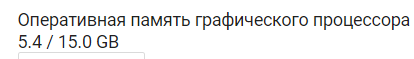

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
%%time
prompt = "Who is Alan Turing?"
prompt_template=f'''[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>
{prompt}[/INST]

'''

print("\n\n*** Generate:")

input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=100)
print(tokenizer.decode(output[0]))



*** Generate:
<s> [INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature. If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>
Who is Alan Turing?[/INST]

Alan Turing (1912-1954) was a British mathematician, computer scientist, and codebreaker who made significant contributions to the fields of computer science, mathematics, and artificial intelligence. He is widely regarded as the father of computer science and artificial intelligence.
Turing was born in London, England, and was educated at Cambridge University, where he earned a degree in mathematics. During World Wa

#Llama-2 7b with AWQ


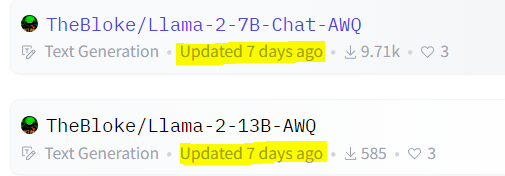

In [ ]:
https://github.com/mit-han-lab/llm-awq

In [ ]:
!pip install https://github.com/vllm-project/vllm/releases/download/v0.2.2/vllm-0.2.2+cu118-cp310-cp310-manylinux1_x86_64.whl

In [ ]:
# Install vLLM.
!pip3 install vllm

In [ ]:
!pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!python3 -m vllm.entrypoints.api_server --model TheBloke/Llama-2-7b-Chat-AWQ --quantization awq

In [ ]:
!pip install autoawq

In [ ]:
from vllm import LLM, SamplingParams

prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]

llm = LLM(model="TheBloke/Llama-2-7b-Chat-AWQ", quantization="awq")

WARNING 11-30 12:49:03 config.py:140] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 11-30 12:49:03 llm_engine.py:72] Initializing an LLM engine with config: model='TheBloke/Llama-2-7b-Chat-AWQ', tokenizer='TheBloke/Llama-2-7b-Chat-AWQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=awq, seed=0)
INFO 11-30 12:49:03 tokenizer.py:31] For some LLaMA V1 models, initializing the fast tokenizer may take a long time. To reduce the initialization time, consider using 'hf-internal-testing/llama-tokenizer' instead of the original tokenizer.


model.safetensors:   0%|          | 0.00/3.89G [00:00<?, ?B/s]

INFO 11-30 12:50:08 llm_engine.py:207] # GPU blocks: 1019, # CPU blocks: 512


In [ ]:
sampling_params = SamplingParams(temperature=0.95, top_p=0.95, top_k=40, max_tokens=512)

In [ ]:
%%time
outputs = llm.generate(prompts, sampling_params)

# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"\nPrompt: {prompt!r}, Generated text: {generated_text!r}\n")


Processed prompts: 100%|██████████| 4/4 [00:20<00:00,  5.22s/it]


Prompt: 'Hello, my name is', Generated text: " Ashley and I'm a college student studying journalism. I'm doing a story on the local food bank and I was wondering if I could interview you. The food bank has been a vital resource for many people in our community, providing food and other essentials to those who are struggling. I would love to learn more about the food bank and the impact it has had on the community.\nThanks for considering my request!\n\n---\n\nHello Ashley,\n\nI'm glad to hear that you're interested in learning more about the local food bank. It's a wonderful organization that has been making a real difference in the lives of many people in our community. I'm more than happy to talk to you about it.\nWhen and where would you like to schedule the interview? I'm available most afternoons or evenings. Please let me know what works best for you.\n\n---\n\nAwesome, thank you for getting back to me! I was thinking of coming by the food bank tomorrow afternoon at 2 pm. Would 

In [ ]:
%%time
outputs = llm.generate(prompts, sampling_params)

# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"\nPrompt: {prompt!r}, Generated text: {generated_text!r}\n")


Processed prompts: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Prompt: 'Hello, my name is', Generated text: ' X, and I am a 25-year-old woman. I'


Prompt: 'The president of the United States is', Generated text: ' the head of the executive branch of the federal government and is one of the most'


Prompt: 'The capital of France is', Generated text: ' Paris. A city of fashion, art, and romance. From the icon'


Prompt: 'The future of AI is', Generated text: ' not just about technology, but also about ethics and governance.\nAI'

CPU times: user 452 ms, sys: 1.9 ms, total: 454 ms
Wall time: 1.53 s


In [ ]:
%%time
sampling_params = SamplingParams(temperature=0.95, top_p=0.8)

outputs = llm.generate(["Alan Turing is"], sampling_params)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

CPU times: user 633 ms, sys: 4.54 ms, total: 638 ms
Wall time: 682 ms


In [ ]:
# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"\nPrompt: {prompt!r}, Generated text: {generated_text!r}\n")


Prompt: 'Alan Turing is', Generated text: ' a highly influential figure in computer science and artificial intelligence, known for his work'



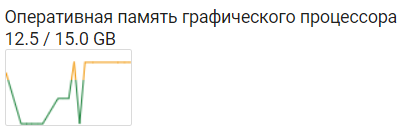

Inference time:

1) GPU inference time - 10.9 s.
